# Experiments to mimic wikipedia-api behavior with elasticsearch

The goal of these experiments is to fine-tune the elasticsearch query in order to get results as close to those provided by the wikipedia-api as possible. To do so, we select a random sample of the manually tagged course descriptions, and use the wikipedia-api as ground truth.

**Disclaimer**: 100% similarity with the wikipedia-api is most likely not achievable in the current setting. It seems like wikipedia uses semantic matching including synonyms (e.g. 'gastronomy' yields results like 'French cuisine', which only includes the term gastronomy once in the page content excluding the references), which is not supported in our current elasticsearch index.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

from concept_detection.interfaces.es import ES
from concept_detection.interfaces.wp import WP
from concept_detection.interfaces.db import DB

from concept_detection.test.courses.compare import *

In [3]:
db = DB()
wikified_course_descriptions = db.query_wikified_course_descriptions()

# Set of all keywords manually tagged by students in the course descriptions
keyword_list = list(set([result.keywords for course_id in wikified_course_descriptions for result in wikified_course_descriptions[course_id]]))

random.seed(0)
sampled_keyword_list = random.sample(keyword_list, 100)

In [4]:
es = ES()
wp = WP()

In [5]:
def compare_wp_es(keyword_list, sizes):
    stats = {size: [] for size in sizes}
    for keywords in keyword_list:
        # Get results from wikipedia-api
        wp_results = wp.search(keywords)
        wp_page_ids = [result.page_id for result in wp_results]
        
        # Get results from elasticsearch
        es_results = es.search(keywords)
        es_page_ids = [result.page_id for result in es_results]

        for size in sizes:
            stats[size].append(confusion_stats(es_page_ids[:size], wp_page_ids[:size]))

    return stats

In [45]:
def compare_wp_es_title_boost(keyword_list, sizes, boosts):
    sizes = [10, 3, 1]
    
    
    stats = {
        size: {boost: [] for boost in boosts}
        for size in sizes
    }
    for keywords in keyword_list:
        # Get results from wikipedia-api
        wp_results = wp.search(keywords)
        wp_page_ids = [result.page_id for result in wp_results]
        
        # Get results from elasticsearch
        es_page_ids = {boost: [] for boost in boosts}
        for boost in boosts:
            if boost >= 0:
                es_results = es.search_boost_title(keywords, boost=boost)
            else:
                es_results = es.search_penalize_title(keywords, penalty=-boost)
            
            es_page_ids[boost] = [result.page_id for result in es_results]

            for size in sizes:
                stats[size][boost].append(confusion_stats(es_page_ids[boost][:size], wp_page_ids[:size]))

    return stats

In [13]:
sizes = [10, 3, 1]

stats = compare_wp_es(sampled_keyword_list, sizes)

In [13]:
avgs = {
    size: np.mean([confusion['r'] for confusion in stats[size]])
    for size in stats
}

avgs

{10: 0.321, 3: 0.3833333333333333, 1: 0.56}

In [46]:
boosts = [-5, -2, -1, -0.5, -0.2, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5]

title_boost_stats = compare_wp_es_title_boost(sampled_keyword_list, sizes, boosts)

In [55]:
title_boost_avgs = {
    size: {
        boost: np.mean([confusion['r'] for confusion in title_boost_stats[size][boost]])
        for boost in title_boost_stats[size]
    }
    for size in title_boost_stats
}

optimal_boosts = {size: max(title_boost_avgs[size], key=title_boost_avgs[size].get) for size in title_boost_avgs}
optimal_boosts

{10: 0.3, 3: 0.3, 1: 0.5}

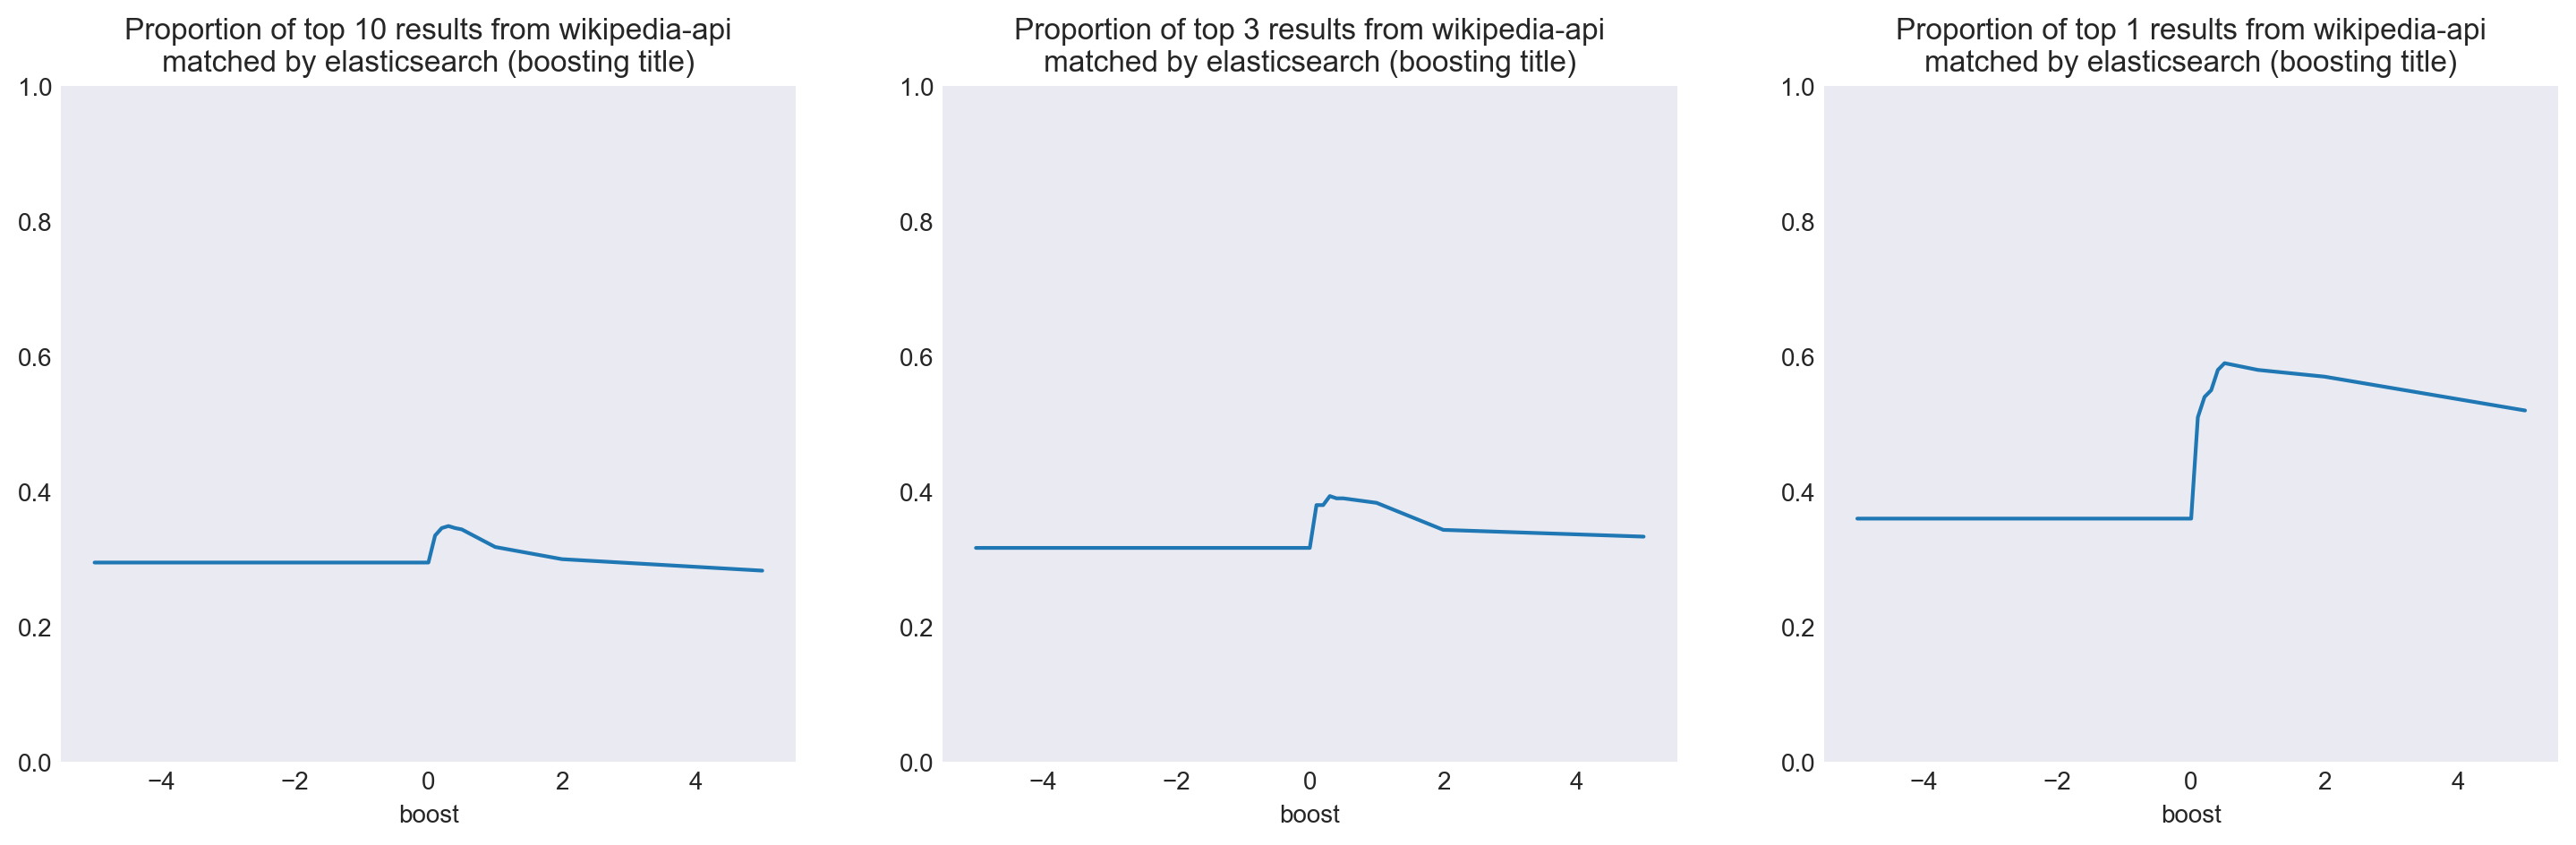

In [56]:
fig, axs = plt.subplots(1, len(title_boost_avgs), figsize=(18, 5), dpi=200)
i = 0
for size in title_boost_avgs:
    x = list(title_boost_avgs[size].keys())
    y = list(title_boost_avgs[size].values())
    
    axs[i].plot(x, y)
    
    axs[i].set_xlabel('boost')
    axs[i].set_ylim([0, 1])
    axs[i].set_title(f'Proportion of top {size} results from wikipedia-api\nmatched by elasticsearch (boosting title)')
        
    i += 1

The optimal value as boost for title is 0.3. This means that the clause to search in the page title should be given ~1/3 importance with respect to the clause to search in the page content.